In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import collections

from tqdm import tqdm, tqdm_notebook

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)

import torch
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import gc
gc.enable()

## Preprocessing

In [2]:
train_transaction = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

print(train.shape)
print(test.shape)

(590540, 433)
(506691, 432)


## Drop columns and Standard Scaling

In [3]:
def dropper(column_name, train, test):
    train = train.drop(column_name, axis=1)
    test = test.drop(column_name, axis=1)
    return train, test

del_columns = ['TransactionDT']

for col in del_columns:
    train, test = dropper(col, train, test)

def scaler(scl, column_name, data):
    data[column_name] = scl.fit_transform(data[column_name].values.reshape(-1,1))
    return data

scl_columns = ['TransactionAmt', 'card1', 'card3', 'card5', 'addr1', 'addr2']

for col in scl_columns:
    train = scaler(StandardScaler(), col, train)
    test = scaler(StandardScaler(), col, test)

# AutoEncoder

## Preprocessing

In [4]:
y_train = train['isFraud'].copy()

# Drop target
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test
    
# Fill in NaNs
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

gc.collect()

20

In [5]:
print(X_train.columns)

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=431)


In [6]:
print(X_test.columns)

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=431)


In [7]:
# TODO: change to Label Count Endocing
# Label Encoding

for f in X_train.columns:
    f_t = 0
    if f[0:2]=='id':
        f_t = f[:2] + '-' + f[3:]
    else:
        f_t = f
    if X_train[f].dtype=='object' or X_test[f_t].dtype=='object': 

        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f_t].values))
        
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f_t] = lbl.transform(list(X_test[f_t].values)) 
        
gc.collect()

0

In [8]:
print(X_train.head())
print(X_test.head())

               TransactionAmt  ProductCD     card1  card2     card3  card4  \
TransactionID                                                                
2987000             -0.278167          4  0.821695 -999.0 -0.281828      2   
2987001             -0.443327          4 -1.457558  404.0 -0.281828      3   
2987002             -0.317889          4 -1.068263  490.0 -0.281828      4   
2987003             -0.355521          4  1.679858  567.0 -0.281828      3   
2987004             -0.355521          1 -1.102133  514.0 -0.281828      3   

                  card5  card6     addr1     addr2  ...  id_31  id_32  id_33  \
TransactionID                                       ...                        
2987000       -1.388767      2  0.238510  0.074098  ...      0 -999.0      0   
2987001       -2.358595      2  0.336798  0.074098  ...      0 -999.0      0   
2987002       -0.806870      3  0.385943  0.074098  ...      0 -999.0      0   
2987003       -1.994910      3  1.820960  0.074098  .

In [9]:
def splitter(data, ratio=0.2):
    num = int(ratio*len(data))
    return data[num:], data[:num]

X_train, X_val = splitter(X_train)
y_train, y_val = splitter(y_train)

# Check number of data
print(len(X_train), len(X_val), len(y_train), len(y_val))

472432 118108 472432 118108


In [10]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472432 entries, 3105108 to 3577539
Columns: 431 entries, TransactionAmt to DeviceInfo
dtypes: float64(400), int64(31)
memory usage: 1.5 GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 431 entries, TransactionAmt to DeviceInfo
dtypes: float64(400), int64(31)
memory usage: 1.6 GB
None


In [11]:
xtr = torch.FloatTensor(X_train.values)
del X_train
xts = torch.FloatTensor(X_test.values)
#del X_test


xvl = torch.FloatTensor(X_val.values) 

xdl = DataLoader(xtr,batch_size=1000)
tdl = DataLoader(xts,batch_size=1000)
vdl = DataLoader(xvl,batch_size=1000)


#print(len(X_train.values), len(X_test.values), len(X_val.values))
gc.collect()


0

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, length):
        super().__init__()
        self.lin1 = nn.Linear(length,20)
        self.lin2 = nn.Linear(20,10)
        self.lin7 = nn.Linear(10,20)
        self.lin8 = nn.Linear(20,length)
        
        self.drop2 = nn.Dropout(0.05)
        
        self.lin1.weight.data.uniform_(-2,2)
        self.lin2.weight.data.uniform_(-2,2)
        self.lin7.weight.data.uniform_(-2,2)
        self.lin8.weight.data.uniform_(-2,2)

    def forward(self, data):
        x = F.tanh(self.lin1(data))
        x = self.drop2(F.tanh(self.lin2(x)))
        x = F.tanh(self.lin7(x))
        x = self.lin8(x)
        return x

def score(x):
    y_pred = model(V(x))
    x1 = V(x)
    return loss(y_pred,x1).item()

In [13]:
model = AutoEncoder(xtr.shape[1])
loss=nn.MSELoss()
learning_rate = 1e-2
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

AutoEncoder(
  (lin1): Linear(in_features=431, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (lin7): Linear(in_features=10, out_features=20, bias=True)
  (lin8): Linear(in_features=20, out_features=431, bias=True)
  (drop2): Dropout(p=0.05, inplace=False)
)


In [14]:
epochs=10

In [15]:
def train(epochs, model, model_loss):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        losses=[]
        dl = iter(xdl)
        for t in range(len(dl)):
            # Forward pass: compute predicted y and loss by passing x to the model.
            xt = next(dl)
            y_pred = model(V(xt))
            
            l = loss(y_pred,V(xt))
            losses.append(l)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            l.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
            
        val_dl = iter(tdl)
        val_scores = [score(next(val_dl)) for i in range(len(val_dl))]
        
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(l.item())
        model_loss.val_loss.append(np.mean(val_scores))
        print(f'Epoch: {epoch}   Loss: {l.item():.4f}    Val_Loss: {np.mean(val_scores):.4f}')

train(model=model, epochs=epochs, model_loss=model_loss)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0   Loss: 24854918.0000    Val_Loss: 88725112.7199
Epoch: 1   Loss: 24780988.0000    Val_Loss: 88650012.1953
Epoch: 2   Loss: 24716720.0000    Val_Loss: 88584180.3235
Epoch: 3   Loss: 24660678.0000    Val_Loss: 88525572.6598
Epoch: 4   Loss: 24611708.0000    Val_Loss: 88473729.5641
Epoch: 5   Loss: 24568842.0000    Val_Loss: 88427196.4310
Epoch: 6   Loss: 24531744.0000    Val_Loss: 88373519.9467
Epoch: 7   Loss: 24499608.0000    Val_Loss: 88328821.1943
Epoch: 8   Loss: 24471482.0000    Val_Loss: 88304030.7505
Epoch: 9   Loss: 24447204.0000    Val_Loss: 88274464.5434
Epoch: 10   Loss: 24426992.0000    Val_Loss: 88225561.6795
Epoch: 11   Loss: 24407834.0000    Val_Loss: 88196490.0897
Epoch: 12   Loss: 24390486.0000    Val_Loss: 88183439.8018
Epoch: 13   Loss: 24374630.0000    Val_Loss: 88142960.5434
Epoch: 14   Loss: 24359720.0000    Val_Loss: 88116114.7495
Epoch: 15   Loss: 24344976.0000    Val_Loss: 88090643.5010
Epoch: 16   Loss: 24330604.0000    Val_Loss: 88064511.3491
Epoch: 

## Check Loss/ Validation Loss

[24854918.0, 24780988.0, 24716720.0, 24660678.0, 24611708.0, 24568842.0, 24531744.0, 24499608.0, 24471482.0, 24447204.0, 24426992.0, 24407834.0, 24390486.0, 24374630.0, 24359720.0, 24344976.0, 24330604.0, 24316446.0, 24302368.0, 24288550.0, 24274812.0, 24261196.0, 24247678.0, 24234238.0, 24220990.0, 24207710.0, 24194414.0, 24180808.0, 24167762.0, 24154578.0, 24141250.0, 24128202.0, 24115124.0, 24101988.0, 24087366.0, 24072718.0, 24059334.0, 24045822.0, 24033138.0, 24018654.0, 24004054.0, 23990458.0, 23977290.0, 23963898.0, 23950758.0, 23936730.0, 23922706.0, 23908496.0, 23894796.0, 23881478.0, 23868146.0, 23854834.0, 23841512.0, 23828210.0, 23814934.0, 23801750.0, 23788434.0, 23775320.0, 23762034.0, 23748970.0, 23735544.0, 23722404.0, 23709094.0, 23695966.0, 23681360.0, 23666428.0, 23652920.0, 23639652.0, 23626398.0, 23614098.0, 23600348.0, 23586866.0, 23573520.0, 23560542.0, 23547272.0, 23534146.0, 23520924.0, 23507888.0, 23494620.0, 23481442.0, 23468356.0, 23455184.0, 23442032.0, 234

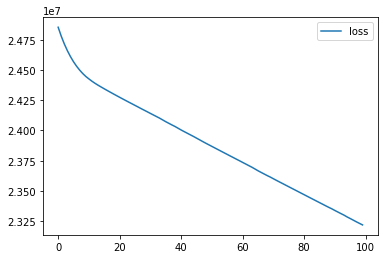

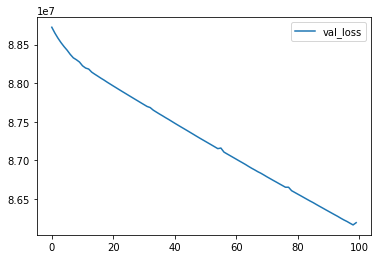

5606

In [16]:
x = np.linspace(0, epochs-1, epochs)
print(model_loss.loss)
print(model_loss.val_loss)
print(x)
plt.plot(x, model_loss.loss, label="loss")
plt.legend()
plt.show()

plt.plot(x, model_loss.val_loss, label="val_loss")
plt.legend()
plt.show()

gc.collect()

### Validation

In [17]:

# Iterate through the dataloader and get predictions for each batch of the test set.
p = iter(vdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

# Create a pandas DF that shows the Autoencoder MSE vs True Labels
error_nonfraud = np.mean(np.power((X_val-preds),2), axis=1)

error_df = pd.DataFrame(data = {'error':error_nonfraud,'true':y_val})
error_df.groupby('true')['error'].describe().reset_index()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


,true,count,mean,std,min,25%,50%,75%,max
0,0,115282.0,6.578391e+07,1.892577e+08,4953.992325,22655.139559,5.854465e+04,2.535275e+07,3.192119e+09
1,1,2826.0,6.178732e+07,1.696484e+08,5366.785524,35082.794950,2.977673e+06,4.182481e+07,2.269127e+09


In [ ]:
print(error_df)

                    isFraud
TransactionID              
3663549        5.581669e-08
3663550        8.545100e-08
3663551        6.577556e-07
3663552        3.471418e-08
3663553        1.428044e-08
...                     ...
4170235        5.312796e-07
4170236        3.380524e-03
4170237        8.385389e-08
4170238        8.401238e-08
4170239        2.378748e-02

[506691 rows x 1 columns]


In [39]:
print(X_val.shape)
print(preds.shape)

(118108, 431)
(506691, 431)


### ROC_AUC

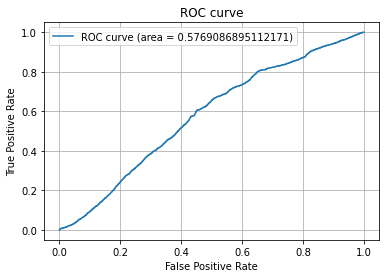

In [18]:
fpr, tpr, thresholds = roc_curve(error_df.true, error_df.error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [19]:
temp_df = error_df[error_df['true'] == 0]
threshold = temp_df['error'].mean() + temp_df['error'].std()
print(f'Threshold: {threshold:.3f}')

Threshold: 255041624.168


### Precision Recall F1-Score

In [20]:
y_pred = [1 if e > threshold else 0 for e in error_df.error.values]
print(classification_report(error_df.true.values,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    115282
           1       0.02      0.07      0.03      2826

    accuracy                           0.90    118108
   macro avg       0.50      0.49      0.49    118108
weighted avg       0.95      0.90      0.93    118108



### Plot Precision Recall

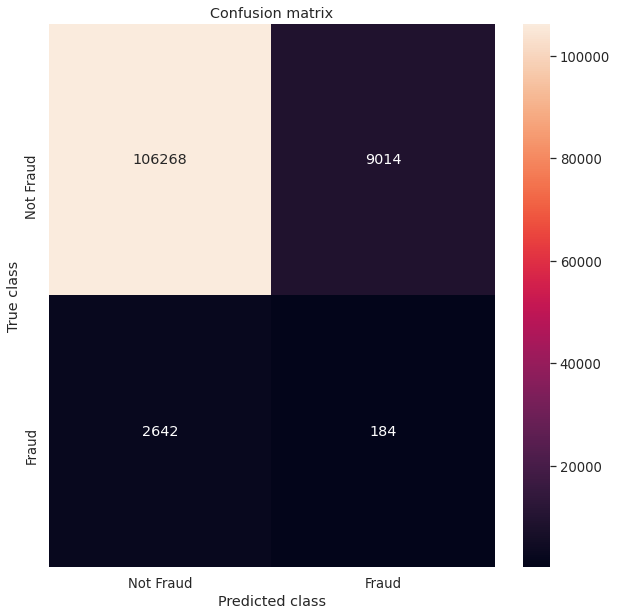

In [21]:
conf_matrix = confusion_matrix(error_df.true, y_pred)

sns.set(font_scale = 1.2)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Plot Precision Recall for each thresholds

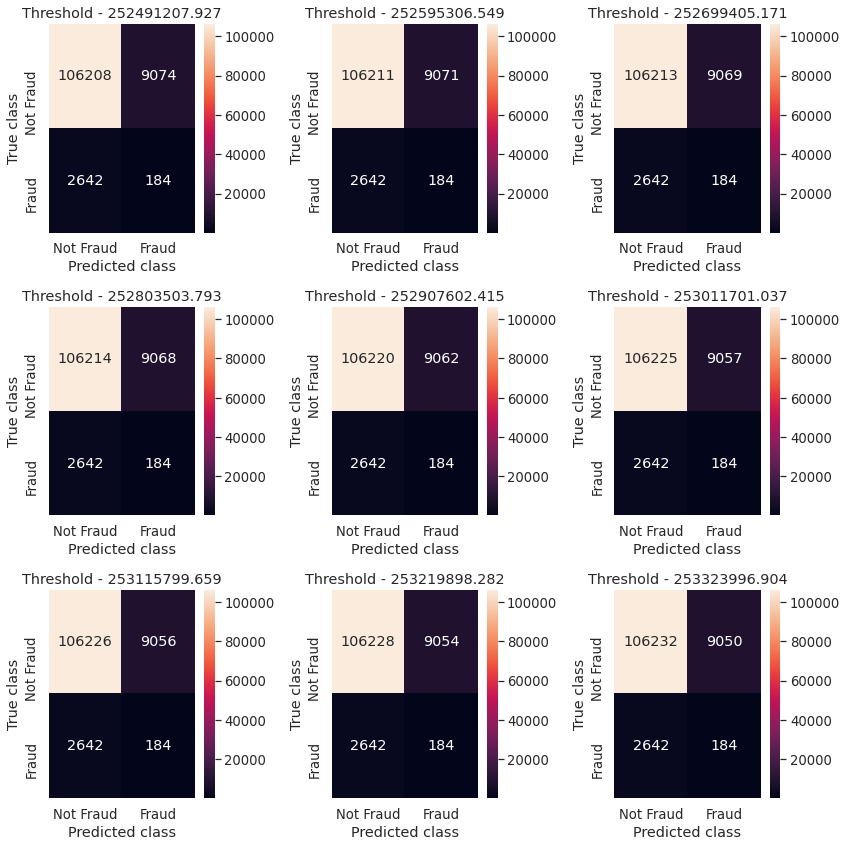

In [22]:
plt.figure(figsize=(12, 12))
m = []
threshold_min = threshold * 0.99
threshold_max = threshold * 1.01

for thresh in np.linspace(threshold_min, threshold_max):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf_matrix = confusion_matrix(error_df.true, y_pred)
    m.append((conf_matrix,thresh))
    
count = 0
for i in range(3):
    for j in range(3):
        plt.subplot2grid((3, 3), (i, j))
        sns.heatmap(m[count][0], xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
        plt.title(f"Threshold - {m[count][1]:.3f}")
        plt.ylabel('True class')
        plt.xlabel('Predicted class')
        plt.tight_layout()
        count += 1
plt.show()

In [23]:
p = iter(tdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

# Create a pandas DF that shows the Autoencoder MSE vs True Labels
error = np.mean(np.power((X_test-preds),2), axis=1)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [29]:
print(preds.shape)
print(error.shape)

(506691, 431)
(506691,)


Num data: 506691
Beyond threshold num data: 30062


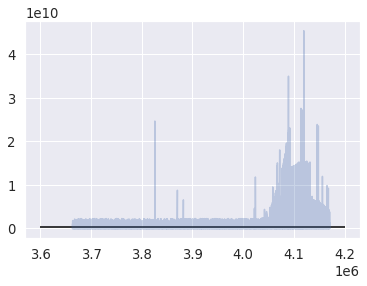

In [24]:
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x-x_min) / (x_max-x_min)
    return x_norm

# min max normalization
#error_df = pd.DataFrame(data={'isFraud':min_max_normalization(error)})
error_df = pd.DataFrame(data={'isFraud':error})

print("Num data: " + str(len(error_df)))
print("Beyond threshold num data: " + str(len(error_df[error_df['isFraud'] > threshold])))
#error_df[error_df['isFraud'] > threshold]

x_min = 3600000
x_max = 4200000
plt.hlines(threshold, x_min, x_max, "black")
plt.plot(error_df, alpha=0.3)
plt.show()

In [25]:
error_df = pd.DataFrame(data={'isFraud':min_max_normalization(error)})
error_df.head()

,isFraud
TransactionID,
3663549,5.581669e-08
3663550,8.545100e-08
3663551,6.577556e-07
3663552,3.471418e-08
3663553,1.428044e-08


In [26]:
sample_submission['isFraud'] = error_df
sample_submission.to_csv('simple_autoencoder.csv')